INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 3403 entries, 1367 to 856
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3403 non-null   int64  
 1   gender             3403 non-null   object 
 2   age                3403 non-null   float64
 3   hypertension       3403 non-null   int64  
 4   heart_disease      3403 non-null   int64  
 5   ever_married       3403 non-null   object 
 6   work_type          3403 non-null   object 
 7   Residence_type     3403 non-null   object 
 8   avg_glucose_level  3403 non-null   float64
 9   bmi                3259 non-null   float64
 10  smoking_status     3403 non-null   object 
 11  stroke             3403 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 345.6+ KB

DESCRIBE:
                 id          age  hypertension  heart_disease  \
count   3403.000000  3403.000000   3403.000000    3403.000000   
mean   36433.

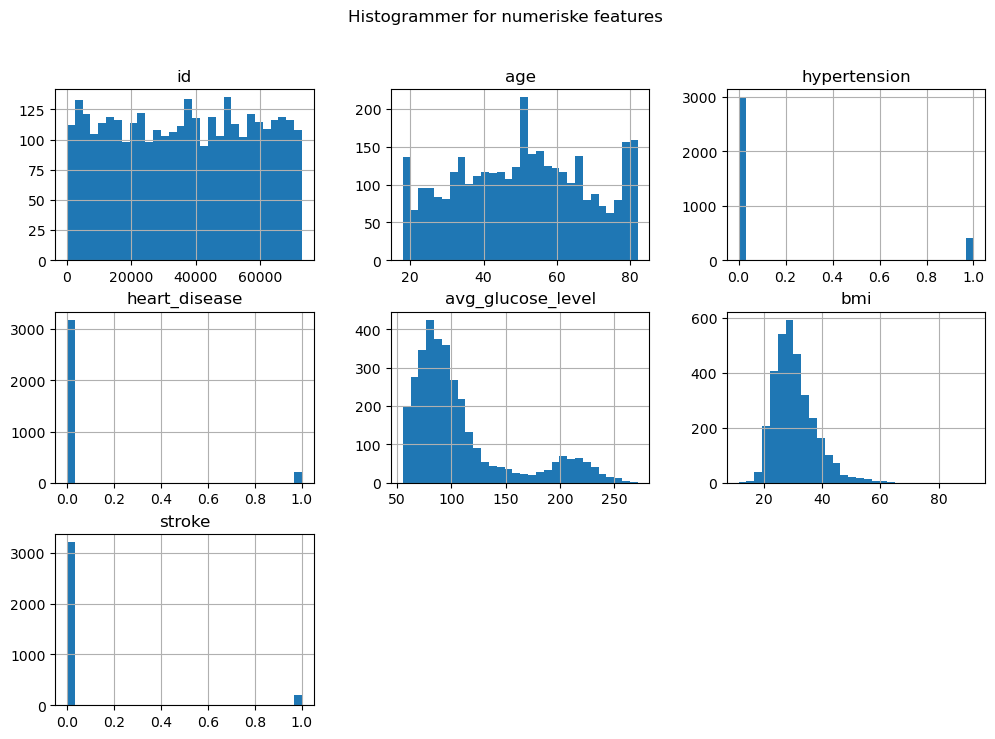

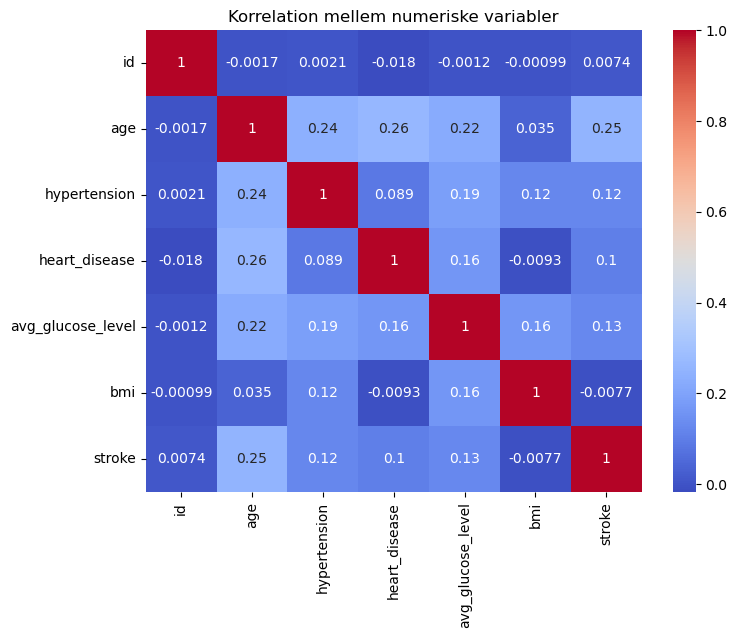


Manglende værdier:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  144
smoking_status         0
stroke                 0
dtype: int64


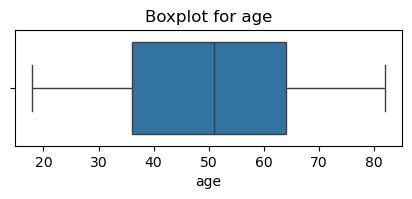

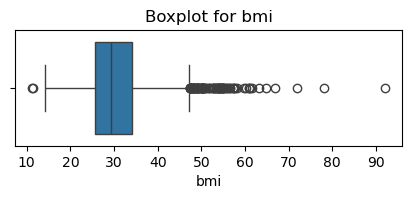

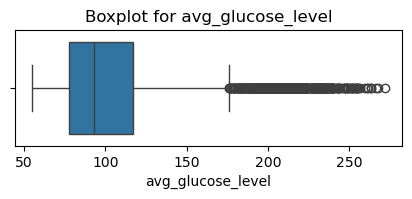

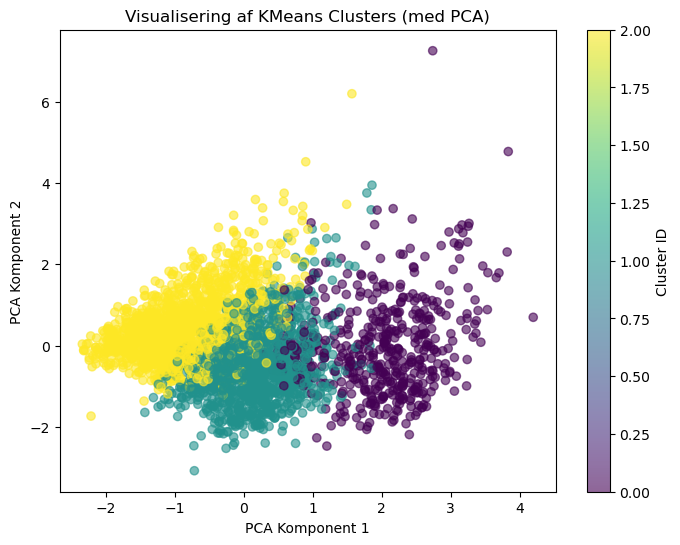


Shape efter transformation: (3259, 21)

🔍 Logistic Regression
RMSE pr fold: [0.51062334 0.53982501 0.56887576 0.52978755 0.554274  ]
Gennemsnitlig RMSE: 0.540677131560118
Standardafvigelse: 0.020012880299431657

🔍 Random Forest
RMSE pr fold: [0.2283577  0.23497813 0.23821937 0.2283577  0.22853302]
Gennemsnitlig RMSE: 0.23168918484350662
Standardafvigelse: 0.004138100876893

🔍 KNN
RMSE pr fold: [0.23497813 0.2283577  0.23497813 0.23169157 0.23186945]
Gennemsnitlig RMSE: 0.23237499675547096
Standardafvigelse: 0.0024663327571844917
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

 Bedste parametre fundet:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

 Klassifikationsrapport på træningsdata:
[[2957  135]
 [  15  152]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3092
           1       0.53      0.91      0.67       167

    accura

In [5]:
# -------------------------------
# AI-25 Exam project Storke Prediction
# Step 1: Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix



#Import alle de 3 modeller vi skal bruge samt vores score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#KMeans import
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Import af Gridesearch 
from sklearn.model_selection import GridSearchCV

# -------------------------------
# Step 2: Load Full Data
# -------------------------------
# Sørg for at 'healthcare-dataset-stroke-data.csv' er i samme mappe
full_data = pd.read_csv(r"C:\Users\moham\OneDrive\Datamatiker\OneDrive\Skrivebord\CPHBusniss\Software Developer\Semester 2\AI og ML\AI\EksamenProject\Exam Project Part 1\healthcare-dataset-stroke-data.csv")


# -------------------------------
# Step 3: Stratified Train/Test/Rensning & Split (20% test based on 'stroke')
# -------------------------------

# Rens datasættet: fjern personer under 18 år
full_data = full_data[full_data["age"] >= 18].reset_index(drop=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(full_data, full_data["stroke"]):
    strat_train_set = full_data.loc[train_index]
    strat_test_set = full_data.loc[test_index]

# Brug kun træningssættet fra nu af
data = strat_train_set.copy()

# 4.1 – Info om datatype og manglende værdier
print("INFO:")
data.info()

# 4.2 – Statistisk oversigt over numeriske kolonner
print("\nDESCRIBE:")
print(data.describe())

# 4.3 – Værdifordeling i kategoriske features
print("\nVALUE COUNTS:")
print("Sex:\n", data["gender"].value_counts(), "\n")
print("Ever Married:\n", data["ever_married"].value_counts(), "\n")
print("Work Type:\n", data["work_type"].value_counts(), "\n")
print("Residence Type:\n", data["Residence_type"].value_counts(), "\n")
print("Smoking Status:\n", data["smoking_status"].value_counts(), "\n")

# 4.4 – Histogrammer for numeriske features
data.hist(bins=30, figsize=(12, 8))
plt.suptitle("Histogrammer for numeriske features")
plt.show()

# 4.5 – Korrelation mellem numeriske features
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Korrelation mellem numeriske variabler")
plt.show()

# 4.6 – Manglende værdier
print("\nManglende værdier:")
print(data.isnull().sum())

# 4.7 – Boxplots for outliers
for col in ["age", "bmi", "avg_glucose_level"]:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# -------------------------------
# Step 5: Forberedelse af data
# -------------------------------

# 1. Byg numerisk_pipeline for hver type data
numerisk_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# 1A. Identificér feature-typer i stroke-datasættet
numeriske_attributter = ["age", "avg_glucose_level", "bmi"]
kategoriske_attributter = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status", "KMeans_cluster"]

# 2 – Opsætning af KMeans Feature Engineering
X_kmeans = data[numeriske_attributter].copy()
X_kmeans_clean = X_kmeans.dropna()   # Drop NaN for at undgå fejl i KMeans og gem indekser
X_kmeans_prepared = numerisk_pipeline.fit_transform(X_kmeans_clean)
data = data.loc[X_kmeans_clean.index].reset_index(drop=True) # Begræns data til de samme rækker der bruges i clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Kør KMeans clustering
data["KMeans_cluster"] = kmeans.fit_predict(X_kmeans_prepared).astype(str)

#2A Visualisering af KMeans clusters vha. PCA
X_pca = PCA(n_components=2).fit_transform(X_kmeans_prepared)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap="viridis", alpha=0.6)
plt.title("Visualisering af KMeans Clusters (med PCA)")
plt.xlabel("PCA Komponent 1")
plt.ylabel("PCA Komponent 2")
plt.colorbar(label="Cluster ID")
plt.show()

# 3. Definér input (X) og målvariabel (y)
X_train = data.drop("stroke", axis=1)
y_train = data["stroke"]


# . Byg kategorisk_pipeline for hver type data
kategorisk_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# 4. Kombinér begge i en samlet pipeline
full_pipeline = ColumnTransformer([
    ("num", numerisk_pipeline, numeriske_attributter),
    ("cat", kategorisk_pipeline, kategoriske_attributter)
])

# 5. Transformér X_train
X_prepared = full_pipeline.fit_transform(X_train)

# Valgfrit: print form
print("\nShape efter transformation:", X_prepared.shape)

# -------------------------------
# Step 6: Træn og sammenlign modeller (shortlisting)

# 1. Liste over modeller vi vil teste
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier()
}

# 2. Test hver model med 5-fold cross-validation
for name, model in models.items():
    print(f"\n🔍 {name}")
    
    # Brug negativ MSE for konsistens med scoring (neg_mean_squared_error → lavere er bedre)
    scores = cross_val_score(model, X_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-scores)
    
    print("RMSE pr fold:", rmse_scores)
    print("Gennemsnitlig RMSE:", rmse_scores.mean())
    print("Standardafvigelse:", rmse_scores.std())

# Step 7: Fine-tune Random Forest med GridSearchCV

# 1. Byg modelinstans
forest_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 2. Definér parametergrid (uden 'auto' i max_features)
param_grid = {
    'n_estimators': [100, 200, 300],              # Flere træer for stabilitet
    'max_depth': [None, 10, 20, 30],              # Begrænset trædybde kan mindske overfitting
    'max_features': ['sqrt', 'log2'],             # Standardvalg i Random Forest
    'min_samples_split': [2, 5, 10],              # Flere splits kan gøre modellen mere generaliserbar
    'min_samples_leaf': [1, 2, 4],                # Mindre risiko for overfitting ved større blade
    'bootstrap': [True]                           # Bootstrap = anbefalet ved regression
}

# 3. Opsæt GridSearchCV
grid_search = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# 4. Træn og find bedste parametre
grid_search.fit(X_prepared, y_train)

# 5. Vis resultater
print("\n Bedste parametre fundet:")
print(grid_search.best_params_)

# 6. Gem den bedste model
best_model = grid_search.best_estimator_

# 7. Evaluer model med klassifikationsmetrikker på træningsdata
y_train_pred = best_model.predict(X_prepared)
print("\n Klassifikationsrapport på træningsdata:")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))


# -------------------------------
# Step 8: Evaluér på test data (dvs. de 20% ) (med KMeans_cluster)
# -------------------------------

# 1. Forbered testdata: adskil X og y
y_test = strat_test_set["stroke"]

# 2. Tilføj KMeans_cluster til testdata (baseret på samme pipeline og model som træning)
X_test_kmeans = strat_test_set[numeriske_attributter].copy()
X_test_kmeans_prepared = numerisk_pipeline.transform(X_test_kmeans)
X_test_clusters = kmeans.predict(X_test_kmeans_prepared).astype(str)

# 3. Opret X_test med cluster-feature inkluderet
X_test = strat_test_set.copy()
X_test["KMeans_cluster"] = X_test_clusters

# 4. Transformér X_test med den samme pipeline som i træning
X_test_prepared = full_pipeline.transform(X_test)

# 5. Brug den bedste model til at forudsige
final_predictions = best_model.predict(X_test_prepared)

# 6. Klassifikationsevaluering
print("📊 Endelig evaluering på test-sæt:")
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))
print("\nClassification Report:\n", classification_report(y_test, final_predictions))

# -------------------------------
# Step 9: Gem pipeline og model til brug i applikation
# -------------------------------

# Gem den færdige pipeline og model
joblib.dump(full_pipeline, "Exam_pipeline.pkl")
joblib.dump(best_model, "Exam_model.pkl")
joblib.dump(kmeans, "kmeans_model.pkl") 
print("✅ Pipeline, model og Kmeans er gemt som 'Exam_pipeline.pkl' & 'Exam_model.pkl' &'kmeans_model.pkl'")



***A: Frame the Problem***

Vi har valgt at arbejde med emnet "slagtilfælde", som er en medicinsk tilstand og en af de førende dødsårsager på verdensplan. Derfor vil vi udvikle et værktøj, der kan hjælpe med at screene patienter og forudsige, om de har en potentiel risiko for at få en hjerneblødning, baseret på forskellige helbreds- og livsstilsfaktorer som alder, blodglukoseniveau, BMI, køn, rygestatus og mere.

Forretningsmålet er at udvikle et værktøj, der kan hjælpe sundhedspersonale med at forudsige, om en patient tilhører en risikogruppe for at få et slagtilfælde. Formålet er at muliggøre tidlig indsats og forebyggende behandling, som i sidste ende kan redde liv.

Det, vi ønsker at forudsige, er en binær målvariabel, hvor stroke har værdien 0 eller 1. Da datasættet er ubalanceret, er det vigtigt at være omhyggelig i valget af model. Derfor har vi valgt at bruge klassifikationsmodeller fremfor regressionsmodeller. Vi evaluerer resultaterne med klassifikationsmetrikker som F1-score, precision, recall og confusion matrix.


---

***B: Get the data***

• Gem en kopi af test-sættet (fx 20%) – brug StratifiedShuffleSplit

Vi arbejder med datasættet "Stroke Prediction Dataset" fra Kaggle. Det indeholder 5110 personer med sundhedsoplysninger.

Målvariablen er stroke, som angiver hvorvidt en person har fået et slagtilfælde (1) eller ej (0). De øvrige kolonner omfatter blandt andet:

* gender: Mand/kvinde/andet

* age: Alder i år

* hypertension: Højt blodtryk (0/1)

* heart_disease: Hjertesygdom (0/1)

* ever_married: Har personen været gift

* work_type: Type af arbejde (private, public, children osv.)

* Residence_type: Urban eller rural

* avg_glucose_level: Gennemsnitligt blodsukkerniveau

* bmi: Body Mass Index

* smoking_status: Rygervaner

* stroke: Målvariabel

Vi stratificerede vores split baseret på stroke, da datasættet er meget ubalanceret (ca. 5% har haft slagtilfælde). Det sikrer, at både trænings- og test-sæt indeholder en repræsentativ fordeling af positive og negative cases. Det er vigtigt for at få en fair model.

Vi har gemt test-sættet (20%) og bruger kun træningsdata (80%) til al dataanalyse, forberedelse og modeltræning. Test-sættet bliver først brugt sidst til den endelige evaluering af modellen.


**Vigtigt Info:**  Det er vigtigt at holde test-sættet "rent", så vi ikke overfitter og kan evaluere ærligt.

**For at resette:** Når vi prøver flere modeller, opretter vi nye instanser for at starte forfra uden tidligere træning.

**Vi gemmer vores model:** Den endelige model og pipeline bliver gemt med joblib, så den kan genbruges fx i en app eller præsentation.



---

***C: Explore the data***

Brug .info(), .describe() og visualiseringer for at forstå datastrukturen og fordelingen
Identificér urealistiske værdier, manglende værdier og outliers

Vi startede med at undersøge datasættet for generelle mønstre og fejl. Det viste sig, at datasættet ligner et auto-genereret syntetisk sæt og indeholder urealistiske kombinationer, fx personer på 0–17 år der arbejder, gift og har haft slagtilfælde.

For at rydde op i datasættet valgte vi at fjerne alle personer under 18 år (age < 18), da det ikke er realistisk, at børn arbejder eller har høj risiko for stroke i dette datasæt.

Ved hjælp af .info() og .isnull().sum() kunne vi se, at bmi havde nogle manglende værdier. Disse håndterede vi senere med en SimpleImputer, som udfylder dem med medianen. Det er en robust strategi, der beskytter mod outliers.

Vi brugte .describe() til at analysere de numeriske kolonner og lavede histogrammer og boxplots for age, avg_glucose_level og bmi. Her så vi:

avg_glucose_level har nogle meget høje værdier, men de blev ikke fjernet, da de potentielt kan være relevante for slagtilfælde.

bmi og age ser normale ud, men har enkelte outliers, som vi lader blive, da Random Forest godt kan håndtere dem.

Vi analyserede også de kategoriske features med .value_counts():

Næsten alle personer er enten "Male" eller "Female" – "Other" forekommer kun få gange.

De fleste arbejder i privat sektor.

Mange har aldrig røget.

**Vigtigt Info:**  Urealistiske værdier kan ødelægge modellens læring, og derfor er det vigtigt at rense grundigt.

---

***D: Dataforberedelse***

→ Brug pipelines til at håndtere numeriske og kategoriske data  
→ Tilføj KMeans clustering som ekstra feature  
→ Klar til modeltræning bagefter

Vi forberedte dataene til modellering ved at bygge en pipeline til både numeriske og kategoriske features.

Først definerede vi to separate pipelines:

Numerisk pipeline: Brugte SimpleImputer (median) til at udfylde manglende værdier og StandardScaler til at standardisere age, bmi og avg_glucose_level.

Kategorisk pipeline: Brugte OneHotEncoder med handle_unknown="ignore" til at håndtere kategoriske features som fx gender, work_type og smoking_status.

Vi kombinerede dem i en ColumnTransformer, som sørger for, at hver type feature bliver behandlet korrekt i samme pipeline.

Derudover tilføjede vi en ekstra feature med unsupervised learning:
Vi brugte KMeans clustering på de numeriske features og gemte cluster-ID’et som en ny kategorisk variabel (KMeans_cluster). Denne blev derefter også kodet via OneHotEncoder.

Resultatet er et komplet og transformeret X_train, som er klar til at blive brugt til træning i vores modeller.

**Vigtigt Info**  Pipelines sikrer, at alle transformationer bliver gentaget korrekt på både trænings- og testdata uden datalækage.

---

***E: Træning og model-sammenligning (shortlisting)***

→ Brug 3 forskellige modeller  
→ Evaluer med 5-fold cross-validation  
→ Vælg den bedste til finjustering

Vi testede tre forskellige modeller på det forberedte træningsdatasæt for at finde den, der giver lavest fejl og bedst generaliserer til nye data:

Linear Regression

Random Forest Classifier

K-Nearest Neighbours (KNN)

Alle modeller blev evalueret med 5-fold cross-validation, hvor vi brugte F1-score som evalueringsmetrik i stedet for RMSE, da vi arbejder med en klassifikationsopgave og datasættet er ubalanceret. F1-score er velegnet i denne sammenhæng, da den balancerer både precision og recall.

Resultaterne viste følgende:

* Logistic Regression gav en god baseline og var hurtig at træne, men havde svært ved at fange komplekse mønstre i data.

* KNN klarede sig middelgodt, men var følsom over for outliers og havde udfordringer med den høje dimensionalitet.

* Random Forest Classifier præsterede bedst samlet set. Den gav den højeste F1-score og var mere stabil på tværs af    fold, samtidig med at den håndterede både ubalance og ikke-lineære mønstre effektivt.

Derfor valgte vi Random Forest Classifier som vores kandidat til videre optimering.

**Vigtigt Info** Brug altid cross-validation til at sammenligne modeller fair og undgå tilfældige resultater fra én træning/test-split.

---

***F: Fine-tuning af Random Forest Classifier med GridSearchCV***

→ Optimer hyperparametre med GridSearchCV  
→ Vælg bedste kombination baseret på RMSE  
→ Evaluer den færdigtrænede model på træningsdata

Efter vi havde shortlistet Random Forest Classifier som bedste model, gik vi videre med at finjustere den ved hjælp af GridSearchCV. Vi definerede et parametergrid med kombinationer af:

n_estimators (antal træer)

max_depth (trædybde)

max_features (hvor mange features hvert træ ser på)

min_samples_split og min_samples_leaf (for at kontrollere overfitting)

bootstrap (om træerne skal trækkes med tilbagelægning)

Vi brugte F1-score som evalueringsmetrik og satte cv=5 for at køre 5-fold cross-validation på hver kombination. Det tog lidt længere tid, men gav os mulighed for at finde den kombination af hyperparametre, som gav bedst balance mellem præcision og recall.

Vi evaluerede modellen på hele træningssættet. Vi brugte følgende metrikker:

* Confusion Matrix

* Classification Report (som inkluderer F1-score, precision og recall for hver klasse)

Resultatet viste, at modellen var i stand til at identificere de fleste positive stroke-cases uden at give alt for mange falske positiver. Det indikerer, at modellen har lært mønstre og ikke bare gætter ud fra majoriteten.


**Vigtigt Info** GridSearch kan tage lang tid, men giver en bedre og mere robust model.

---

***G: Endelig evaluering på test-sæt***

→ Brug test-sættet som var gemt fra starten  
→ Forbered og transformér testdata præcis som træningsdata  
→ Evaluer den færdige model

Til sidst evaluerede vi vores færdigtrænede og tunede Random Forest Classifier-model på det test-sæt, vi havde gemt tidligere (20%). Det sikrer en ærlig vurdering af modellens generaliseringsevne.

Vi sørgede for at forberede testdata på samme måde som træningsdata:

Vi fjernede personer under 18 år (samme filtrering)

Vi transformerede de numeriske værdier med den samme pipeline

Vi tilføjede KMeans_cluster-feature til testdata med den samme KMeans-model som blev brugt under træning

Vi anvendte den samlede pipeline til at transformere X_test

Vi brugte derefter den bedste model (best_model) til at lave forudsigelser på testdata og målte følgende performance:

* Confusion Matrix

* Classification Report (som inkluderer F1-score, precision og recall)

Evalueringen viste at modellen kunne identificere positive cases på testdata med fornuftig præcision og recall. Det tyder på, at modellen ikke er overfittet til træningsdata og generaliserer godt, hvilket er vigtigt især når vi arbejder med et ubalanceret datasæt.


**Vigtigt Info** Testdata bruges kun én gang – det er modellens eksamen.

---

***H: Gem pipeline og model***

→ Gem både pipeline og model med joblib  
→ Klar til brug i applikation

Efter vi havde evalueret modellen, gemte vi både vores dataforberedelses-pipeline og den færdigtrænede model med joblib. Det gør det muligt at genbruge hele løsningen uden at skulle træne modellen igen.

* Exam_pipeline.pkl indeholder alle transformationer (imputing, skalering, one-hot encoding)

* Exam_model.pkl er den tunede Random Forest-model med de bedste parametre

* kmeans_model.pkl gemmer KMeans-modellen, så vi kan tilføje samme cluster-feature til nye data i fremtiden.

Med disse to filer kan vi indlæse pipeline og model og forudsige på nye data, fx i en fremtidig applikation eller præsentation.

**Vigtigt Info** Gem altid både pipeline og model samt kmeans – så undgår man mismatch mellem træning og produktion

---

***I: Refleksion over processen***

Vi oplevede undervejs, at der var stor forskel på at arbejde med regression og klassifikation. I starten brugte vi regressionsmodeller, men fandt hurtigt ud af, at det ikke gav mening i forhold til det problem, vi arbejdede med – nemlig at forudsige en binær variabel (stroke: 0 eller 1). Derfor besluttede vi at skifte tilgang og arbejde videre med klassifikationsmodeller i stedet.

Efter vi skiftede til klassifikationsmodeller, blev det også tydeligt, at vi skulle evaluere modellen anderledes. Vi valgte at bruge F1-score, precision, recall og confusion matrix, da det giver et meget bedre billede af modellens evne til at finde dem, der faktisk har risiko for slagtilfælde – især når data er ubalanceret.

Vi oplevede, at modellen klarede sig fornuftigt både på træningsdata og testdata. Der var en forskel i præcision og recall mellem de to sæt, men ikke i en grad der tyder på overfitting. Brug af class_weight='balanced' og F1-score som optimeringsmål i GridSearchCV hjalp os med at tage højde for skævheden i datasættet.

En vigtig del af vores tilgang var også, at vi brugte KMeans clustering som en ekstra feature. Det var ikke en metode vi havde brugt før, men det gav os mulighed for at fange mønstre i de numeriske data, som ikke kunne ses direkte i korrelationer. Det var en kreativ måde at forbedre vores model på.

Alt i alt har vi fået en bedre forståelse for hele processen fra dataforståelse og forberedelse til modeltræning, evaluering og brug af pipelines. Det har givet os indsigt i, hvor vigtigt det er at vælge den rigtige modeltype og metrikker, især når man arbejder med ubalancerede datasæt.

---



***J: Brug af AI (ChatGPT)***

Under projektet brugte vi ChatGPT som støtte til forståelse og afklaring:

Vi fik hjælp til at forklare og forstå modeller og parametre, fx hvordan verbose=2 og n_jobs=-1 fungerer i GridSearchCV, og hvilke andre værdier man kunne bruge.

Når vi stødte på fejl i vores kode eller var i tvivl om syntax eller funktionalitet, brugte vi AI til at finde løsninger og forklaringer.

Vi søgte også efter definitioner og begreber, som vi kunne have glemt undervejs, da det hele stadig er nyt for os.

Til sidst brugte vi AI til at rette og forbedre tekst og forklaringer, så det blev mere læsbart og præcist.

Alt i alt har vi fået en bedre forståelse for både teknikken bag og hvordan man bruger machine learning i praksis – og vi føler os mere sikre på, hvordan man bygger og evaluerer en maskinlæringsmodel fra start til slut.

---